<a href="https://colab.research.google.com/github/sakshirokade/BE-Project/blob/main/Final_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

In [ ]:
!pip install facenet-pytorch
!pip install opencv-python

In [ ]:
import torch
import torchvision

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

Torch version: 2.2.2+cu121
Torchvision version: 0.17.2+cu121


In [ ]:
!pip install cmake

!pip install face_recognition


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<IPython.core.display.Javascript object>

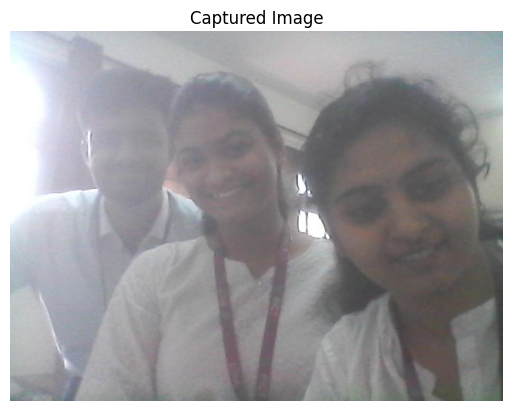

In [ ]:
from IPython.display import Javascript, display
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {{
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = '📸 Take Photo';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({{video: true}});
            document.body.appendChild(div);
            document.body.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            stream.getTracks().forEach(track => track.stop());
            div.remove();
            video.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }}
        takePhoto({0});
    '''.format(quality))

    display(js)
    data = eval_js("takePhoto({})".format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    return filename

# Take photo
filename = take_photo()

# Load and show image
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Captured Image")
plt.show()

In [ ]:
# First Draft
import cv2
import torch
import os
import time
import numpy as np
import pandas as pd
from datetime import datetime
from ultralytics import YOLO
from google.colab import files
from facenet_pytorch import InceptionResnetV1

# Step 1: Upload and select video
uploaded = files.upload()
video_path = list(uploaded.keys())[0]
cap = cv2.VideoCapture(video_path)

# Step 2: Load YOLOv8 model
model = YOLO("yolov8n.pt")
device = torch.device("cpu")
model.to(device)

# Step 3: Load FaceNet for feature embedding
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Constants
CONFIDENCE_THRESHOLD = 0.5
PROCESS_EVERY_N_FRAMES = 1
frame_count = 0
known_embeddings = {}
attendance_tracker = {}

# Output video writer
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' codec for .mp4
out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (frame_width, frame_height))

# Function: Identity assignment
def assign_identity(embedding, y_norm):
    best_match = None
    highest_sim = 0
    for name, known_embed in known_embeddings.items():
        sim = torch.nn.functional.cosine_similarity(
            torch.tensor(embedding), torch.tensor(known_embed), dim=0).item()
        if sim > 0.8 and sim > highest_sim:
            best_match = name
            highest_sim = sim

    if best_match:
        return best_match

    label = "Teacher" if y_norm < 0.4 else "Student"
    count = sum(1 for k in known_embeddings if k.startswith(label))
    new_name = f"{label}{count + 1}"
    known_embeddings[new_name] = embedding
    return new_name

# Function: Face embedding extractor
def get_face_embedding(face_img):
    try:
        face_tensor = torch.tensor(face_img).permute(2, 0, 1).float().unsqueeze(0).to(device)
        face_tensor /= 255.0
        return facenet(face_tensor)[0].detach().cpu().numpy()
    except:
        return None

# Step 4: Frame-by-frame processing
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % PROCESS_EVERY_N_FRAMES != 0:
        continue

    results = model(frame)[0]
    persons = results.boxes

    if persons is None or len(persons) == 0:
        out.write(frame)
        continue

    for i, box in enumerate(persons.xyxy):
        cls = int(persons.cls[i])
        conf = float(persons.conf[i])
        if conf < CONFIDENCE_THRESHOLD or model.names[cls] != "person":
            continue

        x1, y1, x2, y2 = map(int, box)
        face_crop = frame[y1:y2, x1:x2]
        embedding = get_face_embedding(face_crop)
        if embedding is None:
            continue

        y_center_norm = (y1 + y2) / 2 / frame.shape[0]
        identity = assign_identity(embedding, y_center_norm)

        # Attentiveness = (1 - normalized_y_center) * 100
        attentiveness = max(0, min(100, round((1 - y_center_norm) * 100)))

        # Track student attentiveness
        if "Student" in identity:
            attendance_tracker.setdefault(identity, []).append(attentiveness)

        # Draw label on frame
        label = f"{identity} | {attentiveness}%"
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    out.write(frame)
    time.sleep(0.03)

# Step 5: Attendance Calculation
final_attendance = {}
for student, scores in attendance_tracker.items():
    avg = sum(scores) / len(scores)
    status = "Present" if avg >= 40 else "Absent"
    final_attendance[student] = f"{status} ({round(avg, 2)}%)"

# Step 6: Save attendance as Excel
df = pd.DataFrame(final_attendance.items(), columns=["Student ID", "Attendance Status"])
df.to_excel("final_attendance.xlsx", index=False)

# Cleanup
cap.release()
out.release()
cv2.destroyAllWindows()

# Download files
files.download("output.mp4")
files.download("final_attendance.xlsx")


Saving Teacher Teaching the Students Inside a Classroom - Free Stock Videos.mp4 to Teacher Teaching the Students Inside a Classroom - Free Stock Videos (10).mp4

0: 384x640 7 persons, 2 bottles, 1 cup, 1 bowl, 5 chairs, 1 dining table, 1 book, 257.2ms
Speed: 3.4ms preprocess, 257.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 1 cup, 5 chairs, 1 dining table, 1 book, 256.8ms
Speed: 2.6ms preprocess, 256.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 1 cup, 5 chairs, 1 dining table, 1 book, 277.5ms
Speed: 2.9ms preprocess, 277.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bottle, 2 cups, 4 chairs, 1 book, 159.7ms
Speed: 2.8ms preprocess, 159.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 1 cup, 5 chairs, 1 laptop, 173.9ms
Speed: 3.3ms preprocess, 173.9ms inference, 1.5ms postpro

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Second Draft
#Imports
import cv2
import torch
import os
import time
import numpy as np
import pandas as pd
from datetime import datetime
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from google.colab import drive, files
from facenet_pytorch import InceptionResnetV1
import threading

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
output_dir = "/content/drive/MyDrive/SmartSurveillance/"
os.makedirs(output_dir, exist_ok=True)

# Load YOLOv8 Model (people detection only)
model = YOLO("yolov8n.pt")  # Faster inference
device = torch.device("cpu")
model.to(device)

# FaceNet model for embeddings (simplified use)
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Ask for webcam or upload
use_webcam = input("Use live camera? (yes/no): ").strip().lower() == "yes"
if use_webcam:
    cap = cv2.VideoCapture(0)
else:
    uploaded = files.upload()
    video_path = list(uploaded.keys())[0]
    cap = cv2.VideoCapture(video_path)

# Output video settings
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_dir + 'output_analysis.mp4', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

# Configuration
CONFIDENCE_THRESHOLD = 0.6
frame_count = 0
PROCESS_EVERY_N_FRAMES = 1

student_attendance = {}
known_faces = {}
log_data = []

# Processing function
def process_frame(frame, frame_id):
    global student_attendance, known_faces
    results = model(frame)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    confs = results[0].boxes.conf.cpu().numpy()
    cls = results[0].boxes.cls.cpu().numpy()

    people = []
    for i, (box, conf, c) in enumerate(zip(boxes, confs, cls)):
        if conf < CONFIDENCE_THRESHOLD or int(c) != 0:  # class 0 = person
            continue
        x1, y1, x2, y2 = map(int, box)
        people.append((x1, y1, x2, y2))

    student_id = 1
    teacher_id = 1
    student_count = 0
    attentive_count = 0

    for (x1, y1, x2, y2) in people:
        person_crop = frame[y1:y2, x1:x2]
        label = ""
        face_found = False

        try:
            person_tensor = torch.tensor(person_crop).permute(2, 0, 1).float().unsqueeze(0).to(device)
            embedding = facenet(person_tensor).detach().cpu().numpy().flatten()
            face_found = True
        except:
            embedding = None

        if y1 < frame.shape[0] // 3:  # Simple heuristic: upper part of frame
            label = f"Teacher{teacher_id}"
            teacher_id += 1
        else:
            label = f"Student{student_id}"
            student_id += 1
            student_count += 1

        # Attentiveness calculation
        attentiveness = 0

        if face_found:
            # Estimate how centered the person is in frame
            center_x = (x1 + x2) // 2
            frame_center_x = frame.shape[1] // 2
            distance_from_center = abs(center_x - frame_center_x)
            max_distance = frame.shape[1] // 2

            # Closer to center = more attentive (simple proxy)
            attentiveness = max(0, 100 - int((distance_from_center / max_distance) * 100))
        else:
            attentiveness = 0

        # Save to attendance log
        if label not in student_attendance:
            student_attendance[label] = []
        student_attendance[label].append(attentiveness)

        # Show on frame
        attention_text = f"{label} ({attentiveness}%)"
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0 if attentiveness > 50 else 0), 2)
        cv2.putText(frame, attention_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0 if attentiveness > 50 else 0), 2)

    attention_percent = int((attentive_count / student_count) * 100) if student_count > 0 else 0
    log_data.append([frame_id, datetime.now().strftime("%Y-%m-%d %H:%M:%S"), student_count, attentive_count, attention_percent])
    return frame


# Read frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    if frame_count % PROCESS_EVERY_N_FRAMES == 0:
        processed_frame = process_frame(frame, frame_count)
        out.write(processed_frame)
    time.sleep(0.03)

cap.release()
out.release()
cv2.destroyAllWindows()

# Attendance summary
final_attendance = {}
for student, attentions in student_attendance.items():
    avg = sum(attentions) / len(attentions)
    final_attendance[student] = "Present" if avg >= 40 else "Absent"

# Save logs
log_df = pd.DataFrame(log_data, columns=["Frame", "Timestamp", "Total Students", "Attentive Students", "Attentiveness (%)"])
log_df.to_excel(os.path.join(output_dir, "attention_log.xlsx"), index=False)

attendance_df = pd.DataFrame(final_attendance.items(), columns=["Student ID", "Attendance"])
attendance_df.to_excel(os.path.join(output_dir, "final_attendance.xlsx"), index=False)

print("Analysis complete. Check your Google Drive > SmartSurveillance folder.")

Mounted at /content/drive
Use live camera? (yes/no): no


Saving inputvideo.mp4 to inputvideo (1).mp4

0: 384x640 7 persons, 2 bottles, 1 cup, 1 bowl, 5 chairs, 1 dining table, 1 book, 159.8ms
Speed: 2.4ms preprocess, 159.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 1 cup, 5 chairs, 1 dining table, 1 book, 161.6ms
Speed: 3.3ms preprocess, 161.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 1 cup, 5 chairs, 1 dining table, 1 book, 147.0ms
Speed: 2.7ms preprocess, 147.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bottle, 2 cups, 4 chairs, 1 book, 242.0ms
Speed: 2.6ms preprocess, 242.0ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 1 cup, 5 chairs, 1 laptop, 256.1ms
Speed: 2.4ms preprocess, 256.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bottle, 4 chairs, 597.5ms
Speed: 6.4ms preprocess, 

In [ ]:
# Final code

# IMPORTS
import cv2
import torch
import os
import numpy as np
import pandas as pd
from datetime import datetime
from ultralytics import YOLO
from google.colab import drive, files
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms

# INITIAL SETUP
drive.mount('/content/drive', force_remount=True)
output_dir = "/content/drive/MyDrive/SmartSurveillance/"
os.makedirs(output_dir, exist_ok=True)

# Load YOLOv8 model (person detection)
model = YOLO("yolov8n.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Video input
use_webcam = input("Use live camera? (yes/no): ").strip().lower() == "yes"
if use_webcam:
    cap = cv2.VideoCapture(0)
    width, height = int(cap.get(3)), int(cap.get(4))
else:
    uploaded = files.upload()
    video_path = list(uploaded.keys())[0]
    cap = cv2.VideoCapture(video_path)
    width, height = int(cap.get(3)), int(cap.get(4))

# VIDEO WRITER
output_video_path = os.path.join(output_dir, "processed_output.mp4")
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = cap.get(cv2.CAP_PROP_FPS) or 25
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# CONFIGURATION
CONFIDENCE_THRESHOLD = 0.6
frame_count = 0
PROCESS_EVERY_N_FRAMES = 2
teacher_id = 1
student_id = 1
student_attendance = {}

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# MAIN LOOP
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % PROCESS_EVERY_N_FRAMES == 0:
        results = model(frame)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()
        cls = results[0].boxes.cls.cpu().numpy()

        people = []
        for i, (box, conf, c) in enumerate(zip(boxes, confs, cls)):
            if conf < CONFIDENCE_THRESHOLD or int(c) != 0:
                continue
            x1, y1, x2, y2 = map(int, box)
            people.append((x1, y1, x2, y2))

        for (x1, y1, x2, y2) in people:
            if y1 < frame.shape[0] // 3:
                label = f"Teacher{teacher_id}"
                teacher_id += 1
                box_color = (0, 0, 255)
            else:
                label = f"Student{student_id}"
                student_id += 1
                box_color = (0, 255, 0)

            face_found = False
            try:
                person_crop = frame[y1:y2, x1:x2]
                person_tensor = transform(person_crop).unsqueeze(0).to(device)
                _ = facenet(person_tensor).detach()
                face_found = True
            except:
                pass

            attentiveness = 0
            if face_found:
                center_x = (x1 + x2) // 2
                frame_center_x = frame.shape[1] // 2
                distance_from_center = abs(center_x - frame_center_x)
                max_distance = frame.shape[1] // 2
                attentiveness = max(0, 100 - int((distance_from_center / max_distance) * 100))

            # Save attentiveness only for students
            if "Student" in label:
                if label not in student_attendance:
                    student_attendance[label] = []
                student_attendance[label].append(attentiveness)

            # Draw box & label
            cv2.rectangle(frame, (x1, y1), (x2, y2), box_color, 2)
            cv2.putText(frame, f"{label} ({attentiveness}%)", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, box_color, 2)

    out.write(frame)
    frame_count += 1

cap.release()
out.release()

# SAVE CSVs
# Detailed attentiveness log
log_df = pd.DataFrame.from_dict(student_attendance, orient='index').transpose()
log_csv = os.path.join(output_dir, "attentiveness_log.csv")
log_df.to_csv(log_csv, index=False)

# Summary report
attendance_summary = []
for person, scores in student_attendance.items():
    avg_att = round(sum(scores) / len(scores), 2)
    status = "Present" if avg_att >= 40 else "Absent"
    attendance_summary.append({"Name": person, "Avg_Attentiveness": avg_att, "Status": status})

summary_df = pd.DataFrame(attendance_summary)
summary_csv = os.path.join(output_dir, "attendance_summary.csv")
summary_df.to_csv(summary_csv, index=False)

# DONE
print("Processed video saved to:", output_video_path)
print("Attentiveness log saved to:", log_csv)
print("Attendance summary saved to:", summary_csv)


Mounted at /content/drive


KeyboardInterrupt: Interrupted by user

In [ ]:
#Trying to add integrate live footage here
import cv2
import torch
import os
import time
import numpy as np
import pandas as pd
import json
from ultralytics import YOLO
from google.colab import files, drive
from facenet_pytorch import InceptionResnetV1

#Setup

# Mount Google Drive for saving outputs
drive.mount('/content/drive', force_remount=True)
output_dir = "/content/drive/MyDrive/SmartSurveillance/"
os.makedirs(output_dir, exist_ok=True)

# Load YOLOv8 model (person detection)
model = YOLO("yolov8n.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load FaceNet model for face embeddings
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Config
CONFIDENCE_THRESHOLD = 0.6
PROCESS_EVERY_N_FRAMES = 1

# Embeddings persistence files
embedding_file = os.path.join(output_dir, 'known_embeddings.json')

# Functions for embedding persistence

def save_embeddings(path, embeddings_dict):
    serializable = {k: v.tolist() for k, v in embeddings_dict.items()}
    with open(path, 'w') as f:
        json.dump(serializable, f)

def load_embeddings(path):
    if not os.path.exists(path):
        return {}
    with open(path, 'r') as f:
        data = json.load(f)
    return {k: np.array(v) for k, v in data.items()}

# Load known embeddings (if any)
known_embeddings = load_embeddings(embedding_file)

#Identity assignment

def assign_identity(embedding, y_norm):
    best_match = None
    highest_sim = 0
    embedding_tensor = torch.tensor(embedding)
    for name, known_embed in known_embeddings.items():
        known_tensor = torch.tensor(known_embed)
        sim = torch.nn.functional.cosine_similarity(embedding_tensor, known_tensor, dim=0).item()
        if sim > 0.8 and sim > highest_sim:
            best_match = name
            highest_sim = sim

    if best_match:
        return best_match

    # New identity assignment by vertical position
    label = "Teacher" if y_norm < 0.4 else "Student"
    count = sum(1 for k in known_embeddings if k.startswith(label))
    new_name = f"{label}{count + 1}"
    known_embeddings[new_name] = embedding
    return new_name

# Face embedding extraction

def get_face_embedding(face_img):
    try:
        face_tensor = torch.tensor(face_img).permute(2, 0, 1).float().unsqueeze(0).to(device)
        face_tensor /= 255.0
        embedding = facenet(face_tensor)[0].detach().cpu().numpy()
        return embedding
    except Exception as e:
        print(f"Embedding extraction error: {e}")
        return None

# Select input source

use_webcam = input("Use live camera? (yes/no): ").strip().lower() == "yes"
if use_webcam:
    cap = cv2.VideoCapture(0)
else:
    uploaded = files.upload()
    video_path = list(uploaded.keys())[0]
    cap = cv2.VideoCapture(video_path)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video_path = os.path.join(output_dir, 'output_analysis.mp4')
out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (frame_width, frame_height))

frame_count = 0
attendance_tracker = {}

print("Starting processing... Press Ctrl+C to stop if using webcam.")

# Processing loop

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % PROCESS_EVERY_N_FRAMES != 0:
        continue

    results = model(frame)[0]
    persons = results.boxes

    if persons is None or len(persons) == 0:
        out.write(frame)
        continue

    for i, box in enumerate(persons.xyxy):
        cls = int(persons.cls[i])
        conf = float(persons.conf[i])
        if conf < CONFIDENCE_THRESHOLD or model.names[cls] != "person":
            continue

        x1, y1, x2, y2 = map(int, box)
        face_crop = frame[y1:y2, x1:x2]

        embedding = get_face_embedding(face_crop)
        if embedding is None:
            continue

        y_center_norm = (y1 + y2) / 2 / frame_height
        identity = assign_identity(embedding, y_center_norm)

        attentiveness = max(0, min(100, round((1 - y_center_norm) * 100)))

        if "Student" in identity:
            attendance_tracker.setdefault(identity, []).append(attentiveness)

        label = f"{identity} | {attentiveness}%"
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (x1, y1 - 8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    out.write(frame)
    if use_webcam:
        # Display live frame
        cv2.imshow("Smart Surveillance", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Stopping capture by user request.")
            break
    else:
        # Slight delay for video file processing
        time.sleep(0.03)

# Attendance finalization

final_attendance = {}
for student, scores in attendance_tracker.items():
    avg = sum(scores) / len(scores)
    status = "Present" if avg >= 40 else "Absent"
    final_attendance[student] = f"{status} ({round(avg, 2)}%)"

# Save attendance Excel
df = pd.DataFrame(final_attendance.items(), columns=["Student ID", "Attendance Status"])
attendance_excel_path = os.path.join(output_dir, "final_attendance.xlsx")
df.to_excel(attendance_excel_path, index=False)

# Save embeddings persistently
save_embeddings(embedding_file, known_embeddings)

# Cleanup
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Processing complete. Video saved at: {output_video_path}")
print(f"Attendance saved at: {attendance_excel_path}")

# Download outputs if running in Colab
files.download(output_video_path)
files.download(attendance_excel_path)


In [ ]:
# Imports
import cv2
import torch
import os
import numpy as np
import pandas as pd
from datetime import datetime
from ultralytics import YOLO
from google.colab import drive, files
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
output_dir = "/content/drive/MyDrive/SmartSurveillance/"
os.makedirs(output_dir, exist_ok=True)

# Load YOLOv8 model
model = YOLO("yolov8n.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load FaceNet for facial embeddings
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Choose input source
use_webcam = input("Use live camera? (yes/no): ").strip().lower() == "yes"
if use_webcam:
    cap = cv2.VideoCapture(0)
else:
    uploaded = files.upload()
    video_path = list(uploaded.keys())[0]
    cap = cv2.VideoCapture(video_path)

# Output video writer
width, height = int(cap.get(3)), int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS) or 25
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(os.path.join(output_dir, "output_analysis.mp4"), fourcc, fps, (width, height))

# Configuration
CONFIDENCE_THRESHOLD = 0.6
PROCESS_EVERY_N_FRAMES = 1
frame_count = 0

# Tracking dictionaries
student_tracker = {}  # {student_id: x_position}
student_attendance_log = {}  # {student_id: [attentiveness_scores]}
student_id_counter = 1

# Image pre-processing for FaceNet
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Main loop
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % PROCESS_EVERY_N_FRAMES == 0:
        results = model(frame)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()
        cls = results[0].boxes.cls.cpu().numpy()

        people = []
        for box, conf, c in zip(boxes, confs, cls):
            if conf >= CONFIDENCE_THRESHOLD and int(c) == 0:
                x1, y1, x2, y2 = map(int, box)
                people.append((x1, y1, x2, y2))

        teacher_id = 1
        for (x1, y1, x2, y2) in people:
            person_crop = frame[y1:y2, x1:x2]
            label = ""
            face_found = False

            try:
                person_tensor = transform(person_crop).unsqueeze(0).to(device)
                _ = facenet(person_tensor)
                face_found = True
            except:
                pass

            if y1 < frame.shape[0] // 3:
                label = f"Teacher{teacher_id}"
                teacher_id += 1
                box_color = (0, 0, 255)
            else:
                center_x = (x1 + x2) // 2
                matched_id = None
                for sid, prev_x in student_tracker.items():
                    if abs(center_x - prev_x) < 50:
                        matched_id = sid
                        break

                if matched_id is None:
                    matched_id = student_id_counter
                    student_id_counter += 1

                student_tracker[matched_id] = center_x
                label = f"Student{matched_id}"
                box_color = (0, 255, 0)

                # Calculate attentiveness
                attentiveness = 0
                if face_found:
                    frame_center_x = frame.shape[1] // 2
                    distance_from_center = abs(center_x - frame_center_x)
                    max_distance = frame.shape[1] // 2
                    attentiveness = max(0, 100 - int((distance_from_center / max_distance) * 100))

                # Log attentiveness
                if matched_id not in student_attendance_log:
                    student_attendance_log[matched_id] = []
                student_attendance_log[matched_id].append(attentiveness)

            # Draw bounding box and label
            cv2.rectangle(frame, (x1, y1), (x2, y2), box_color, 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, box_color, 2)

    out.write(frame)
    frame_count += 1

cap.release()
out.release()

# Save attentiveness log to CSV
attendance_data = []
for student_id, scores in student_attendance_log.items():
    avg_attentiveness = sum(scores) / len(scores) if scores else 0
    attendance_data.append({
        "StudentID": student_id,
        "AvgAttentiveness(%)": round(avg_attentiveness, 2),
        "TotalFrames": len(scores)
    })

df = pd.DataFrame(attendance_data)
csv_path = os.path.join(output_dir, "student_attendance_log.csv")
df.to_csv(csv_path, index=False)

print("Processing complete. Output video and CSV saved.")


In [ ]:
# Imports
import cv2
import torch
import os
import numpy as np
import pandas as pd
from datetime import datetime
from ultralytics import YOLO
from google.colab import drive, files
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
output_dir = "/content/drive/MyDrive/SmartSurveillance/"
os.makedirs(output_dir, exist_ok=True)

# Load YOLOv8 model
model = YOLO("yolov8n.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load FaceNet for facial embeddings
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Choose input source
use_webcam = input("Use live camera? (yes/no): ").strip().lower() == "yes"
if use_webcam:
    cap = cv2.VideoCapture(0)
else:
    uploaded = files.upload()
    video_path = list(uploaded.keys())[0]
    cap = cv2.VideoCapture(video_path)

# Output video writer
width, height = int(cap.get(3)), int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS) or 25
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(os.path.join(output_dir, "output_analysis.mp4"), fourcc, fps, (width, height))

# Configuration
CONFIDENCE_THRESHOLD = 0.6
PROCESS_EVERY_N_FRAMES = 1
frame_count = 0

# Tracking dictionaries
student_tracker = {}  # {student_id: x_position}
student_attendance_log = {}  # {student_id: [attentiveness_scores]}
student_id_counter = 1

# Image pre-processing for FaceNet
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Main loop
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % PROCESS_EVERY_N_FRAMES == 0:
        results = model(frame)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()
        cls = results[0].boxes.cls.cpu().numpy()

        people = []
        for box, conf, c in zip(boxes, confs, cls):
            if conf >= CONFIDENCE_THRESHOLD and int(c) == 0:
                x1, y1, x2, y2 = map(int, box)
                people.append((x1, y1, x2, y2))

        teacher_id = 1
        for (x1, y1, x2, y2) in people:
            person_crop = frame[y1:y2, x1:x2]
            label = ""
            face_found = False

            try:
                person_tensor = transform(person_crop).unsqueeze(0).to(device)
                _ = facenet(person_tensor)
                face_found = True
            except:
                pass

            if y1 < frame.shape[0] // 3:
                label = f"Teacher{teacher_id}"
                teacher_id += 1
                box_color = (0, 0, 255)
            else:
                center_x = (x1 + x2) // 2
                matched_id = None
                for sid, prev_x in student_tracker.items():
                    if abs(center_x - prev_x) < 50:
                        matched_id = sid
                        break

                if matched_id is None:
                    matched_id = student_id_counter
                    student_id_counter += 1

                student_tracker[matched_id] = center_x
                label = f"Student{matched_id}"
                box_color = (0, 255, 0)

                # Calculate attentiveness
                attentiveness = 0
                if face_found:
                    frame_center_x = frame.shape[1] // 2
                    distance_from_center = abs(center_x - frame_center_x)
                    max_distance = frame.shape[1] // 2
                    attentiveness = max(0, 100 - int((distance_from_center / max_distance) * 100))

                # Log attentiveness
                if matched_id not in student_attendance_log:
                    student_attendance_log[matched_id] = []
                student_attendance_log[matched_id].append(attentiveness)

            # Draw bounding box and label
            cv2.rectangle(frame, (x1, y1), (x2, y2), box_color, 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, box_color, 2)

            # Display attentiveness live on video for students
            if label.startswith("Student"):
                attentiveness_text = f"Attn: {attentiveness}%"
                cv2.putText(frame, attentiveness_text, (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, box_color, 2)

    out.write(frame)
    frame_count += 1

cap.release()
out.release()

# Save attentiveness log to CSV
attendance_data = []
for student_id, scores in student_attendance_log.items():
    avg_attentiveness = sum(scores) / len(scores) if scores else 0
    attendance_data.append({
        "StudentID": student_id,
        "AvgAttentiveness(%)": round(avg_attentiveness, 2),
        "TotalFrames": len(scores)
    })

df = pd.DataFrame(attendance_data)
csv_path = os.path.join(output_dir, "student_attendance_log.csv")
df.to_csv(csv_path, index=False)

print("Processing complete. Output video and CSV saved.")


Mounted at /content/drive
Use live camera? (yes/no): no


Saving Teacher Teaching the Students Inside a Classroom - Free Stock Videos.mp4 to Teacher Teaching the Students Inside a Classroom - Free Stock Videos (11).mp4

0: 384x640 7 persons, 2 bottles, 1 cup, 1 bowl, 5 chairs, 1 dining table, 1 book, 159.7ms
Speed: 2.8ms preprocess, 159.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 1 cup, 5 chairs, 1 dining table, 1 book, 160.7ms
Speed: 4.1ms preprocess, 160.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 1 cup, 5 chairs, 1 dining table, 1 book, 160.4ms
Speed: 2.7ms preprocess, 160.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bottle, 2 cups, 4 chairs, 1 book, 161.5ms
Speed: 2.1ms preprocess, 161.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bottle, 1 cup, 5 chairs, 1 laptop, 158.9ms
Speed: 2.6ms preprocess, 158.9ms inference, 1.5ms postpro

In [ ]:
# Imports
import cv2
import torch
import os
import numpy as np
import pandas as pd
from datetime import datetime
from ultralytics import YOLO
from google.colab import drive, files
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
output_dir = "/content/drive/MyDrive/SmartSurveillance/"
os.makedirs(output_dir, exist_ok=True)

# Load YOLOv8 model
model = YOLO("yolov8n.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load FaceNet for facial embeddings
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Choose input source
use_webcam = input("Use live camera? (yes/no): ").strip().lower() == "yes"
if use_webcam:
    cap = cv2.VideoCapture(0)
else:
    uploaded = files.upload()
    video_path = list(uploaded.keys())[0]
    cap = cv2.VideoCapture(video_path)

# Output video writer setup
width, height = int(cap.get(3)), int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS) or 25
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(os.path.join(output_dir, "output_analysis.mp4"), fourcc, fps, (width, height))

# Configuration
CONFIDENCE_THRESHOLD = 0.6
PROCESS_EVERY_N_FRAMES = 1
frame_count = 0
MAX_MISSING_FRAMES = 30  # How many frames to keep "lost" students in memory

# Tracking dictionaries
student_tracker = {}       # {student_id: x_position}
student_last_seen = {}     # {student_id: last_frame_number}
student_attendance_log = {}  # {student_id: [attentiveness_scores]}
student_id_counter = 1

# Image pre-processing for FaceNet
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Main processing loop
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % PROCESS_EVERY_N_FRAMES == 0:
        results = model(frame)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()
        cls = results[0].boxes.cls.cpu().numpy()

        people = []
        for box, conf, c in zip(boxes, confs, cls):
            if conf >= CONFIDENCE_THRESHOLD and int(c) == 0:  # Class 0 = person in COCO dataset
                x1, y1, x2, y2 = map(int, box)
                people.append((x1, y1, x2, y2))

        teacher_id = 1
        new_student_tracker = {}

        for (x1, y1, x2, y2) in people:
            person_crop = frame[y1:y2, x1:x2]
            label = ""
            face_found = False

            # Try to detect face for attentiveness (simplified)
            try:
                person_tensor = transform(person_crop).unsqueeze(0).to(device)
                _ = facenet(person_tensor)
                face_found = True
            except:
                pass

            if y1 < frame.shape[0] // 3:
                # Assuming upper part of frame is teacher
                label = f"Teacher{teacher_id}"
                teacher_id += 1
                box_color = (0, 0, 255)  # Red box for teacher
            else:
                center_x = (x1 + x2) // 2
                matched_id = None
                min_dist = float('inf')

                # Find closest existing student within 50 pixels
                for sid, prev_x in student_tracker.items():
                    dist = abs(center_x - prev_x)
                    if dist < 50 and dist < min_dist:
                        min_dist = dist
                        matched_id = sid

                if matched_id is None:
                    matched_id = student_id_counter
                    student_id_counter += 1

                new_student_tracker[matched_id] = center_x
                student_last_seen[matched_id] = frame_count

                label = f"Student{matched_id}"
                box_color = (0, 255, 0)  # Green box for student

                # Calculate attentiveness based on position relative to frame center
                attentiveness = 0
                if face_found:
                    frame_center_x = frame.shape[1] // 2
                    distance_from_center = abs(center_x - frame_center_x)
                    max_distance = frame.shape[1] // 2
                    attentiveness = max(0, 100 - int((distance_from_center / max_distance) * 100))

                # Log attentiveness
                if matched_id not in student_attendance_log:
                    student_attendance_log[matched_id] = []
                student_attendance_log[matched_id].append(attentiveness)

            # Draw bounding box and label
            cv2.rectangle(frame, (x1, y1), (x2, y2), box_color, 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, box_color, 2)

        # Remove students who have disappeared for too long
        to_delete = [sid for sid, last_seen in student_last_seen.items() if frame_count - last_seen > MAX_MISSING_FRAMES]
        for sid in to_delete:
            student_tracker.pop(sid, None)
            student_last_seen.pop(sid, None)
            student_attendance_log.pop(sid, None)

        # Update student tracker for next frame
        student_tracker = new_student_tracker

    out.write(frame)
    frame_count += 1

cap.release()
out.release()

# Save attentiveness log to CSV
attendance_data = []
for student_id, scores in student_attendance_log.items():
    avg_attentiveness = sum(scores) / len(scores) if scores else 0
    attendance_data.append({
        "StudentID": student_id,
        "AvgAttentiveness(%)": round(avg_attentiveness, 2),
        "TotalFrames": len(scores)
    })

df = pd.DataFrame(attendance_data)
csv_path = os.path.join(output_dir, "student_attendance_log.csv")
df.to_csv(csv_path, index=False)

print("Processing complete. Output video and CSV saved.")

Mounted at /content/drive
